In [39]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [44]:
from bellek.dvc.experiment import load_experiments

experiments = load_experiments('prompt-engineering.json')
print(f"{len(experiments)} experiments")
experiments[0]

31 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique-mini',
   'name': 'answerable',
   'split': 'train'},
  'qa': {'model': 'llama-3-70b-tgi',
   'temperature': 0.1,
   'system_prompt': 'excellent-qa.txt',
   'user_prompt_template': 'qc.txt',
   'few_shot_examples': 'empty.json'},
  'run': 1},
 'metrics': {'exact_match': 0.5440628878775341,
  'f1': 0.6516290491337483,
  'fuzzy_match': 0.6073645014480761,
  '2hops': {'exact_match': 0.5870607028753994,
   'f1': 0.6910973146421198,
   'fuzzy_match': 0.6477635782747604},
  '3hops': {'exact_match': 0.5289473684210526,
   'f1': 0.6514964398511577,
   'fuzzy_match': 0.6105263157894737},
  '4hops': {'exact_match': 0.43950617283950616,
   'f1': 0.5298673568826074,
   'fuzzy_match': 0.4765432098765432}}}

In [45]:
df = pd.json_normalize(experiments).drop(columns=["commit", "id", "name"])

param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop_duplicates(subset=param_cols, inplace=True)

# df = df.sort_values(["params.qa.model", "params.qa.prompt", "params.qa.temperature", "params.run"])
df.reset_index(drop=True, inplace=True)
df.head()

,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.run,metrics.exact_match,...,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
0,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,qc.txt,empty.json,1,0.544063,...,0.607365,0.587061,0.691097,0.647764,0.528947,0.651496,0.610526,0.439506,0.529867,0.476543
1,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,icq-line.txt,empty.json,2,0.550000,...,0.600000,0.640000,0.721905,0.690000,0.510000,0.610111,0.550000,0.500000,0.637213,0.560000
2,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,icq-line.txt,empty.json,1,0.550000,...,0.600000,0.640000,0.721905,0.690000,0.510000,0.610111,0.550000,0.500000,0.641213,0.560000
3,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,icq-line.txt,empty.json,3,0.546667,...,0.593333,0.640000,0.721905,0.690000,0.510000,0.611929,0.550000,0.490000,0.637880,0.540000
4,bdsaglam/musique-mini,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,icq-sep.txt,empty.json,3,0.590000,...,0.636667,0.690000,0.780238,0.730000,0.570000,0.660481,0.600000,0.510000,0.641124,0.580000


In [46]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples"])[
        metric_cols[:1]
    ]
    .count()
    .reset_index()
)
mask = run_counts[metric_cols[0]] < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match


In [55]:
# Average metrics over repeated runs (params.run)
df_avg = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples"])[
        metric_cols
    ]
    .mean()
    .reset_index()
)
df_avg[["params.qa.system_prompt", 'params.qa.user_prompt_template', *metric_cols]].sort_values('metrics.2hops.f1', ascending=False)

,params.qa.system_prompt,params.qa.user_prompt_template,metrics.exact_match,metrics.f1,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
2,excellent-qa.txt,icq-sep.txt,0.592222,0.694052,0.642222,0.690000,0.778968,0.730000,0.573333,0.661037,0.610000,0.513333,0.642150,0.586667
5,no-role.txt,cq.txt,0.563333,0.690670,0.626667,0.686667,0.776127,0.766667,0.533333,0.652781,0.553333,0.470000,0.643100,0.560000
0,excellent-qa.txt,cq.txt,0.596667,0.691608,0.646667,0.683333,0.766429,0.730000,0.576667,0.661923,0.610000,0.530000,0.646473,0.600000
7,no-role.txt,icq-sep.txt,0.545556,0.681843,0.612222,0.643333,0.755622,0.723333,0.520000,0.627016,0.543333,0.473333,0.662892,0.570000
8,no-role.txt,iqc.txt,0.521111,0.630209,0.591111,0.630000,0.742511,0.740000,0.503333,0.598380,0.553333,0.430000,0.549736,0.480000
9,no-role.txt,qc.txt,0.521111,0.628650,0.587778,0.636667,0.736035,0.740000,0.490000,0.593137,0.533333,0.436667,0.556778,0.490000
6,no-role.txt,icq-line.txt,0.531111,0.656831,0.594444,0.636667,0.728794,0.716667,0.496667,0.612237,0.536667,0.460000,0.629464,0.530000
3,excellent-qa.txt,iqc.txt,0.517778,0.617535,0.582222,0.616667,0.725924,0.710000,0.510000,0.602606,0.573333,0.426667,0.524076,0.463333
1,excellent-qa.txt,icq-line.txt,0.548889,0.657130,0.597778,0.640000,0.721905,0.690000,0.510000,0.610717,0.550000,0.496667,0.638769,0.553333
4,excellent-qa.txt,qc.txt,0.526910,0.626649,0.585788,0.615687,0.717278,0.689255,0.512982,0.606633,0.573509,0.426502,0.528562,0.465514


In [56]:
mask = df_avg['params.qa.system_prompt'] == 'excellent-qa.txt'
df_target = df_avg.loc[mask].copy()

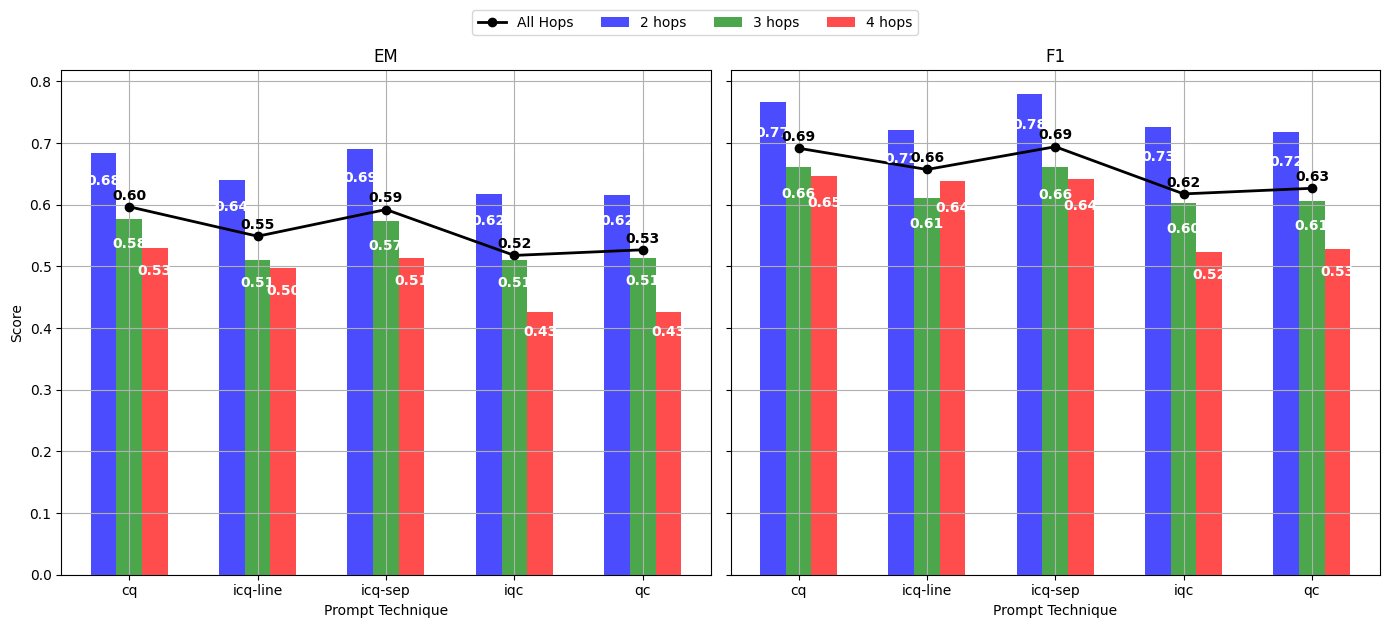

In [57]:
def plot_metric(ax, x, width, prompts, metrics, title, ylabel=None):
    bars_2hops = ax.bar(x - width, metrics["2hops"], width, label="2 hops", color="b", alpha=0.7)
    bars_3hops = ax.bar(x, metrics["3hops"], width, label="3 hops", color="g", alpha=0.7)
    bars_4hops = ax.bar(x + width, metrics["4hops"], width, label="4 hops", color="r", alpha=0.7)

    # Plotting all hops as a line plot
    ax.plot(x, metrics["all"], label="All Hops", color="k", linestyle="-", marker="o", linewidth=2)

    # Adding values inside the bars, just below the top
    for bars in [bars_2hops, bars_3hops, bars_4hops]:
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - (bar.get_height() * 0.05),
                f"{bar.get_height():.2f}",
                ha="center",
                va="top",
                fontsize=10,
                color="white",
                fontweight="bold",
            )

    # Adding values on top of the line plot
    for i, value in enumerate(metrics["all"]):
        ax.text(
            x[i],
            value + 0.007,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Adjust titles and labels
    ax.set_title(title)
    ax.set_xlabel("Prompt Technique")
    ax.set_xticks(x)
    ax.set_xticklabels([prompt.replace(".txt", "") for prompt in prompts])
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.grid(True)


# Creating subplots for Exact Match and F1, separating them for clarity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

width = 0.2  # Bar width adjustment

# Changing the order of prompts to standard, cot-zs, cot-fs, cte
prompts = df_target["params.qa.user_prompt_template"].values
x = np.arange(len(prompts))

# Plotting Exact Match
metrics_em = {
    "2hops": df_target["metrics.2hops.exact_match"].values,
    "3hops": df_target["metrics.3hops.exact_match"].values,
    "4hops": df_target["metrics.4hops.exact_match"].values,
    "all": df_target["metrics.exact_match"].values,
}
plot_metric(ax1, x, width, prompts, metrics_em, title="EM", ylabel="Score")

# Plotting F1
metrics_f1 = {
    "2hops": df_target["metrics.2hops.f1"].values,
    "3hops": df_target["metrics.3hops.f1"].values,
    "4hops": df_target["metrics.4hops.f1"].values,
    "all": df_target["metrics.f1"].values,
}
plot_metric(ax2, x, width, prompts, metrics_f1, title="F1")

# Creating a shared legend outside the plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)

plt.tight_layout()
plt.show()